# Шаблон для проекта по A/B - тестам. 
#Боровой А.А. Поток: "Вольнослушатели" 2023г.

### `chat_id ` из Телеграма:

In [ ]:
chat_id = 897113152

------------------

##  <ins>Задание 1.</ins>

### 0. Запросить у бота в Телеграме условие командой `/get_project1_desc`.

#### Текст задания:


**Контекст**\
Мы считаем, что наш продукт достаточно дорогой для клиента.
У нас есть гипотеза, что уменьшение цены продукта
позволит повысить частоту продаж
и суммарно увеличит доходность продукта.
        
**Тест**\
Мы проводим тест,
в рамках которого контролем является
продажа продукта со старой ценой,
а тестом - продажа продукта с новой ценой.
Целью этого теста
является проверка гипотезы роста доходности
нашего продукта из-за уменьшения тарифа.

**Статистические вводные**\
Уровень значимости 5%.
Мы хотели бы различать 5%-ное
изменение целевой метрики
с вероятностью 80%.

**Процесс продажи устроен следующим образом:**

1.   создаётся задание на звонок человеку;
2.   оператор берёт задание и пытается дозвониться до человека;
3. если не дозванивается, мы несём некоторые затраты на время оператора и поддержку инфраструктуры;
4. если дозванивается, пытается продать наш продукт;
5. если продал, мы имеем некоторый заработок (PV) и повышенные расходы (в том числе на вознаграждение оператора).

#### Импортитуем необходимые для работы библиотеки.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import anderson_ksamp
from scipy.stats import cramervonmises_2samp
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

Подключаем Google-диск (где временно хранятся все данные для проекта).

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Загружаем датасет с историческими данными.

In [ ]:
df = pd.read_csv('gdrive/My Drive/hist_telesales.csv', index_col='ID')

Осмотрим датасет.

In [ ]:
df.head(10)

,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
ID,,,,,
0,1,0,90,0,-90
1,0,0,5,0,-5
2,0,0,68,0,-68
3,1,0,22,0,-22
4,1,0,22,0,-22
5,1,1,367,2397,2030
6,1,1,49,1213,1164
7,0,0,26,0,-26
8,0,0,35,0,-35


Посмотрим численное и текстовое описания столбцов.

In [ ]:
df.describe()

,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
count,72161.000000,72161.000000,72161.000000,72161.000000,72161.000000
mean,0.599881,0.302172,200.581547,482.041352,281.459805
std,0.489926,0.459202,363.748786,814.227243,677.664908
min,0.000000,0.000000,0.000000,0.000000,-4406.000000
25%,0.000000,0.000000,21.000000,0.000000,-54.000000
50%,1.000000,0.000000,59.000000,0.000000,-18.000000
75%,1.000000,1.000000,182.000000,1258.000000,535.000000
max,1.000000,1.000000,6280.000000,41255.000000,41144.000000



**Описание колонок в исторических данных.**

*   **ID** - номер задания на звонок
*   **Флаг дозвона** - 1 если в рамках задания мы дозвонились человеку, иначе 0
* **Флаг продажи** - 1 если в рамках задания мы продали наш продукт человеку, иначе 0
* **Расходы** - сумма затрат на задание
* **PV** - 0 если мы не продали наш продукт, иначе = PV проданного продукта
* **NPV** = PV - Расходы

По условию задачи из приведенных столбцов необходимо выбрать целевую метрику.\
Напомним, что **целевая метрика** - это метрика, на основе которой мы принимаем решение.

### 1. Необходимо выбрать метрику и привести аргументацию.

У нас есть гипотеза о том, что уменьшение цены продукта позволит 
повысить **частоту продаж** и суммарно **увеличит доходность продукта**.\
И решением "в лоб" было бы просто замерить изменение частоты продаж, т.е. *флаг продажи*, но эта метрика не учитывает доходность продукта, 
а считается, что лучшая метрика продукта это та, которая "ближе к деньгам",
поэтому лучше отслеживать более "финансовую" метрику (NPV или PV).
Самой оптимальной целевой метрикой будет **NPV** *("Net Present Value")*, так как эта метрика позволит оценить эффективность изменения цены продукта на основе его доходности, учитывая затраты на продажу.

In [ ]:
target_metric = "NPV"

#### Для корректной работы с датасетом, произведем его предварительный анализ.

In [ ]:
print(f'Размерность датасета: {df.shape}')
print()
print('Типы данных в столбцах:')
print(df.dtypes)

Размерность датасета: (72161, 5)

Типы данных в столбцах:
Флаг дозвона    int64
Флаг продажи    int64
Расходы         int64
PV              int64
NPV             int64
dtype: object


Проверим пропуски в столбцах.



In [ ]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Флаг дозвона - 0%
Флаг продажи - 0%
Расходы - 0%
PV - 0%
NPV - 0%


Посмотрим как распределены значения в столбце "NPV".

<Axes: title={'center': 'График распределения NPV по ID заданий'}, xlabel='ID', ylabel='NPV'>

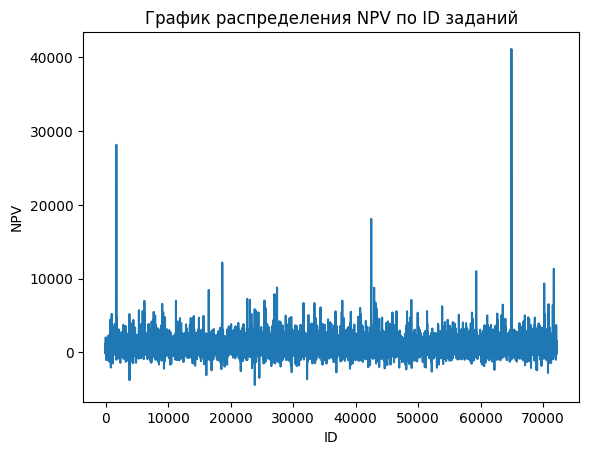

In [ ]:
df['NPV'].plot(title = 'График распределения NPV по ID заданий', ylabel = 'NPV')

<Axes: >

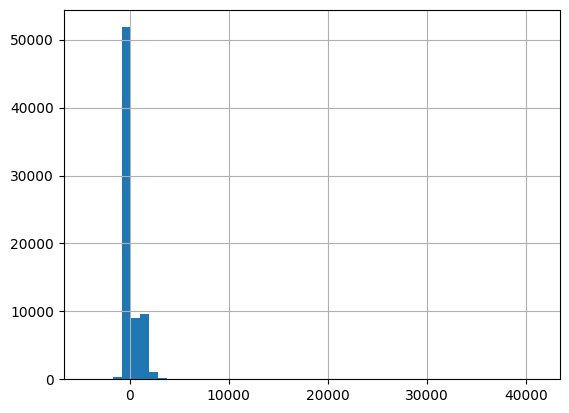

In [ ]:
df['NPV'].hist(bins=50)

<Axes: >

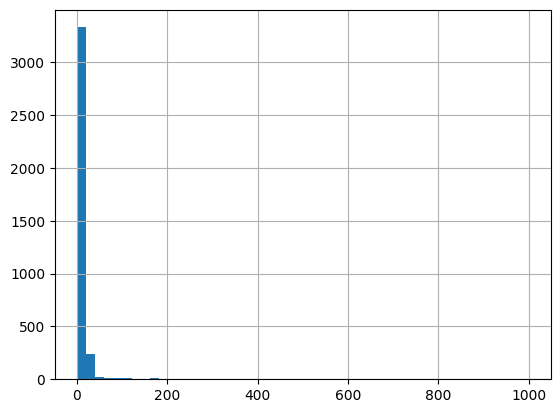

In [ ]:
df['NPV'].value_counts().hist(bins=50)

В графике NPV от ID имеются некоторые значения, сильно отличные от общего числа.

In [ ]:
df.loc[df['NPV'].idxmax()]

Флаг дозвона        1
Флаг продажи        1
Расходы           111
PV              41255
NPV             41144
Name: 64928, dtype: int64

Особых оснований отбрасывать "условные выбросы" у нас нет, флаг дозвона = 1, флаг продажи = 1, значит логика прослеживается.

### 2. Альтернатива в критерии.

**Нулевая гипотеза** утверждает о том, что измение цены продукта, не окажет статистически значимого эффекта на метрику NPV по сравнению с контрольной группой.\
**Альтернативная гипотеза** утверждает, что изменения среднего метрики в тестовой группе будут носить положительный характер, т.е. *среднее по метрике в тестовой группе* будет **больше** *среднего по метрике в контрольной группе*.

In [ ]:
alternative = 'mu_control < mu_test' # односторонняя альтернатива

### 3.1. Каков размер выборки? Привести аргументацию и написать как получилось то или иное число.

Для определения размера выборкии нам необходимы следующие параметры:


1.   MDE (Minimum Detectable Effect) — минимальная разница в метрике, которую хотим заметить: uplift * среднее значение метрики в исторических данных;
2.   uplift — % изменения целевой метрики (в нашем случае 5% или 0.05);
3. std — стандартное отклонение метрики в исторических данных;
4. z_alpha — z значеие, относящееся к вероятности совершить ошибку первого рода (в нашем случае alpha = 5% (0.05));
5. z_beta — z значеие, относящееся к вероятности совершить ошибку второго рода (в нашем случае beta = 20% (0.2));




Произведем расчет размера выборки.

Опредеим MDE.

In [ ]:
uplift = 0.05 # 5%-ое увеличение метрики
mde = df['NPV'].mean() * uplift
print(round(mde, 3))

14.073


Определим среднеквадратическое отклонение.

In [ ]:
std = df['NPV'].std().round(3)
std

677.665

Определим критические значения для Z.

In [ ]:
z_1_alpha = norm.ppf(1-.05) # alpha = 5% (0.05)
z_1_alpha

1.6448536269514722

In [ ]:
z_beta = norm.ppf(0.2) # beta = 20% (0.2)
z_beta

-0.8416212335729142

Определим размер выборки.

In [ ]:
def sample_size(std, mde, z_alpha, z_beta):
  '''
  Функция расчета размера небинарной выборки (односторонняя альтернатива)
  аргументы функции:
  z_alpha - критическое значение z для z(1-alpha);
  z_neta - критическое значение z для z(beta);
  std - срендеквадратичное отклонение;
  mde - MDE (Minimum Detectable Effect)
  '''
  n = (2 * (std ** 2) * (z_alpha - z_beta) ** 2) / (mde ** 2)
  return n

In [ ]:
print(f'Необходимый размер выборок n и m = {round(sample_size(std, mde, z_1_alpha, z_beta),0)} наблюдений')

Необходимый размер выборок n и m = 28672.0 наблюдений


### 3.2. Необходимо запросить у бота в Телеграме выборку полученного размера командой `/get_project1_sample {размер выборки}` и вписать <ins>код выборки</ins>:

In [ ]:
sample_code = 18899 #Код выборки

### 4. Принятие решения. Расписать подробно с аргументами.

#### Загрузка контрольной и тестовой выборок.

Подгрузим сгенерированные ботом выборки, оставим в выборках только столбец с интересующей нас метрикой.

In [ ]:
control = pd.read_csv('gdrive/My Drive/Контроль.csv')
control = control.NPV
test = pd.read_csv('gdrive/My Drive/Тест.csv')
test = test.NPV

Посмотрим, как все подгрузилось.

In [ ]:
control.head()

0    -129
1    1252
2    1205
3      -4
4    1086
Name: NPV, dtype: int64

In [ ]:
test.head()

0    -52
1    -14
2      0
3    943
4    -11
Name: NPV, dtype: int64

#### Проверка Stability index выборок.


Проверим **репрезентативность** наших контрольной и тестовой выборок.\
*Замечание*: Функция не моя.\
Взято отсюда:\
https://github.com/mwburke/population-stability-index

In [ ]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables

    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal

    Returns:
       psi_values: ndarray of psi values for each variable

    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable

        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into

        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [ ]:
si = calculate_psi(control, test)
print(f'Stability Index = {round(si, 4)}')
if si < 0.1:
  print(f'В выборке отстуствуют значимые изменения.')
elif 0.1 <= si < 0.2:
  print(f'В выборке имеются незначительные изменения, которые необходимо исследовать.')
else:
  print(f'В выборке имеется существенное смещение, необходимы изменения, в идеале не использовать выборку.')

Stability Index = 0.0016
В выборке отстуствуют значимые изменения.


#### Выбор и применение статистического критерия.

Поскольку имеем небинарное распределение, выборки независимые, будем использовать **"t-критерий оценки Стьюдента (двухвыборочный)"**.

Проверим, сработает ли корректно критерий на А/А тесте.

In [ ]:
ttest_ind(control, control, equal_var=False) 

Ttest_indResult(statistic=0.0, pvalue=1.0)

Критерий работает корректно, он показал, что p_value = 1, это означает, что выборки идентичны.

Проверим наши выборки:

In [ ]:
alpha = 0.05
results = ttest_ind(
    control, 
    test,
    equal_var=False,
    alternative='less') #‘less’: the mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample.

print(f'p-value = {round(results.pvalue, 4)}')
print('===========================')

if round(results.pvalue, 4) < alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.")
else:
    print("Нулевая гипотеза не отвергается и статзначимых различий в группах нет.")

p-value = 0.0177
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.


#### Выводы:


* Мы видим, что p_value = 0.0177 < alpha = 0.05, следовательно нулевая 
гипотеза H0 о том, что статистически-значимых изменений в группах не будет, **отвергается** в пользу альтернативной гипотезы о наличии в тестовой выборке статзначимых изменений (**увеличения** среднего в метрике NPV с (как минимум) минимально-ожидаемым эффектом) для уровня значимости alpha = 5% и мощности (1-beta) = 80%.
* Таким образом, опираясь на результаты теста мы принимаем решение (или даем рекомендацию) уменьшить цену продукта, в виду того, что это окажет статзначимый эффект на увеличение доходности продукта.
* Повысить чувствительность теста можно, например удалив выбросы в данных (но желательно не более 1%  наблюдений), либо уменьшив дисперсию (CUPED/CUPAC методы).

========================

#### Эксперимент №1 "Чистка данных".

В качестве эксперимента посмотрим, что будет, если мы очистим исторические данные от "условных выбросов" методом межквартильного интервала.

Создадим копию исходного датасета исторических данных.

In [ ]:
df_2 = df.copy()

In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72161 entries, 0 to 72160
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Флаг дозвона  72161 non-null  int64
 1   Флаг продажи  72161 non-null  int64
 2   Расходы       72161 non-null  int64
 3   PV            72161 non-null  int64
 4   NPV           72161 non-null  int64
dtypes: int64(5)
memory usage: 5.3 MB


Очистим данные от выбросов методом межквартильного интервала.

In [ ]:
Q1 = df_2['NPV'].quantile(0.25)
Q3 = df_2['NPV'].quantile(0.75)
IQR = Q3 - Q1
df_clean = df_2[(df_2['NPV'] >= Q1 - 1.5*IQR) & (df_2['NPV'] <= Q3 + 1.5*IQR)]

Посмотрим размерность датасета. Сырой датасет был размерностью (72161, 5).

In [ ]:
df_clean.shape

(67579, 5)

Посмотрим параметры для определения выборки.

Определим MDE.

In [ ]:
uplift = 0.05
mde_clean = df_clean['NPV'].mean() * uplift
print(round(mde_clean, 3))

8.799


Определим СКО для "очищенной" выборки.

In [ ]:
std_clean = df_clean['NPV'].std().round(3)
std_clean

448.708

Посмотрим, какой размер выборки необходим для теста (на основе очищенных исторических данных).

In [ ]:
print(f'Необходимый размер выборок n и m = {round(sample_size(std_clean, mde_clean, z_1_alpha, z_beta),0)} наблюдений')

Необходимый размер выборок n и m = 32156.0 наблюдений


**Вывод:**\
Мы удалили больше 6% значений из исторических данных (6.34%), это достаточно много и среди этих значений могли быть важные для эксперимента данные. Серьезно изменились параметры для определения размера выборки и, как следствие, изменился размер выборки для теста и контроля. В данный момент нельзя утверждать, что данная операция по очистке данных необходима. Нужно детально рассматривать историческую выборку.

#### Эксперимент №2. "Нормальность ГС и выборок. Критерий по итогу проверки".

При решении задания №1 не была проведена проверка на нормальность значений в генеральной совокупности и в выборках из нее (этого не требовало задание), но хотелось бы посмотреть: Возможно ли определить нормальность и как дальше с этими данными работать?

Попробуем сформулировать гипотезу о нормальности распределения значений метрики NPV.\
**Нулевая гипотеза** будет звучать так: Предполагаем, что значения в исторических данных (NPV) распределены по нормальному закону.\
**Альтернативная гипотеза:** Распределение значений не является нормальным.\
Уровень значимости примем 5%.\
Для проверки нормальности распределения применим **критетий Шапиро-Уилка**.

In [ ]:
p_value_norm = shapiro(df['NPV']).pvalue
print(f'p_value = {p_value_norm}')
print('==============')

if (p_value_norm < 0.05):
    print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.")
else:
    print("Нулевая гипотеза не отвергается. Данные распределены по нормальному закону.")

p_value = 0.0
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.


Поскольку тест Шапиро-Уилка показал, что данные получены не из нормального распределения, мы в дальнейшем будем учитывать факт того, что мы **не знаем распределение значений генеральной совокупности**.

Логично предположить, что если значения в генеральной совокупности не распределены по нормальному закону, то и выборки из нее так же не будут иметь нормального распределения, но проверим это утверждение.

In [ ]:
for sample in (test, control):
  p_value_norm = shapiro(sample).pvalue
  print(f'p_value = {p_value_norm}')
  print('==============')

  if (p_value_norm < 0.05):
      print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.")
  else:
      print("Нулевая гипотеза не отвергается. Данные распределены по нормальному закону.")

p_value = 0.0
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.
p_value = 0.0
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, распределение значений не является нормальным.


В виду того, что мы отвергли нулевую гипотезу о нормальном законе распределения в выборках и не знаем распределение данных, применять t-тест стоит с осторожностью. Для выборок, у которых не известно распределение, рекомендется применять непараметрический **U-критерий Манна-Уитни**.\
Проверим работу данного критерия на наших выборках.

In [ ]:
mannwhitneyu_res = mannwhitneyu(control, test, alternative='less')

print(f'p-value = {round(mannwhitneyu_res.pvalue, 4)}')
print('===========================')

if round(mannwhitneyu_res.pvalue, 4) < 0.05:
    print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.")
else:
    print("Нулевая гипотеза не отвергается и статзначимых различий в группах нет.")

p-value = 0.0756
Нулевая гипотеза не отвергается и статзначимых различий в группах нет.


**Вывод:**\
Интересный вывод получен по итогу работы u-критерия Манна-Уитни. Данный критерий указывает на то, что **статзначимых различий между выборками нет**.
Возможно, это связано с тем, что была не до конца понята работа критерия и некоторые параметры, которые присутствуют в критерии, не были учтены как положено. Необходимо детально разбираться в работе критерия.

------------------

##  <ins>Задание 2.</ins>

### 0. Запосить у бота в Телеграме условие командой `/get_project2_desc`.

**Контекст**\
Мы провели Cust Dev и поняли,
что форма авторизации для клиента сложна,
и из-за этого часть клиентов
отваливается в заявочном процессе.\
Мы решили разработать
новый процесс авторизации,
и у нас есть гипотеза,
что он позволит повысить
утилизации наших счетов.
        
**Тест**\
Мы проводим тест,
в рамках которого мы разбиваем весь поток
на две части рановероятно,
где у одной части (контроля) 
старый процесс авторизации,
а у второй части (теста) - новый.\
Целью этого теста
является **повышение утилизаций счёта**.

**Статистические вводные**\
Проверка однородности выбранного параметра
осуществяется с уровнем значимости 2%.\
Уровень значимости 5%.\
Мы хотели бы различать 3%-ное
изменение целевой метрики
с вероятностью 95%.

**Описание данных**

*Процесс оформления кредитной карты (КК) устроен следующим образом:*

1. человек заходит на сайт и заполняет информацию о себе (в том числе возраст и 
доход клиента) для получения кредитной карты;
2. человек проходит скоринг (в том числе в рамках которого оценивается вероятность банкротства клиента);
3. создаётся заявка на оформление кредитной карты;
4. человеку выпускается виртуальная карта, а также предлагается наша услуга к этому счёту;
5. с некоторой вероятностью человек утилизирует счёт (начинает им пользоваться);
6. если человек не утилизирует счёт, мы несём некоторые затраты на время оператора и поддержку инфраструктуры;
7. если человек утилизировал карту, мы имеем некоторый заработок (PV) и повышенные расходы.

Подгрузим исторические данные.

In [ ]:
data = pd.read_csv('gdrive/My Drive/hist_credit_card.csv', index_col = 'ID')

Осмотрим датасет.

In [ ]:
data.head(10)

,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
ID,,,,,,,,
0,19,21620.835463,0.138061,0,102,0,0,-102
1,27,24897.990863,0.035508,1,409,11686,1754,13031
2,50,23989.526947,0.098793,0,16,0,0,-16
3,18,38442.409756,0.365661,1,788,13738,1578,14528
4,24,21291.521612,0.036909,1,1048,6594,2213,7759
5,19,22957.947147,0.021514,1,110,33316,1692,34898
6,27,22217.477344,0.319460,0,57,0,0,-57
7,46,29584.430233,0.324886,1,371,5859,2529,8017
8,27,21730.692059,0.254344,1,712,9981,3758,13027


Посмотрим численное и текстовое описания колонок .

**Описание колонок в исторических данных.**

* **ID** - номер заявки, прошедшей скоринг
* **Возраст** - возраст клиента, указанный при оформлении КК
* **Доход клиента** - доход клиента, указанный при оформлении КК
* **Вероятность банкротства** - оценка вероятности банкротства клиента, полученная с помощью скоринга по параметрам клиента
* **Флаг утилизация счёта** - совершение первой расходной операции на счёте КК
* **Расходы** - сумма затрат на заявку
* **PV КК** - 0 если счёт не утилизирован, иначе = PV кредитной карты
* **PV услуги** - 0 если счёт не утилизирован, иначе = PV этой услуги
* **NPV** = PV КК + PV услуги - Расходы

### 1. Необходимо выбрать метрику и привести аргументацию.

У нас есть гипотеза о том, что новый процесс авторизации **позволит повысить утилизации наших счетов** и мы проводим тест, в рамках которого проверяем повышение утилизации счета. Опираясь на это, рационально в качестве *целевой метрики* рассматривать столбец **Флаг утилизации счета**.

In [ ]:
target_metric_2 = "Флаг утилизации счета"

Проведем краткий анализ датасета с историческими данными.

In [ ]:
print(f'Размерность датасета: {data.shape}')
print()
print('Типы данных в столбцах:')
print(data.dtypes)

Размерность датасета: (123255, 8)

Типы данных в столбцах:
Возраст                      int64
Доход клиента              float64
Вероятность банкротства    float64
Флаг утилизации счёта        int64
Расходы                      int64
PV КК                        int64
PV услуги                    int64
NPV                          int64
dtype: object


Проверим пропуски в столбцах.

In [ ]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Возраст - 0%
Доход клиента - 0%
Вероятность банкротства - 0%
Флаг утилизации счёта - 0%
Расходы - 0%
PV КК - 0%
PV услуги - 0%
NPV - 0%


In [ ]:
data['Флаг утилизации счёта'].value_counts()

1    91399
0    31856
Name: Флаг утилизации счёта, dtype: int64

Посмотрим на графики данных.

<Axes: xlabel='Флаг утилизации счёта', ylabel='Count'>

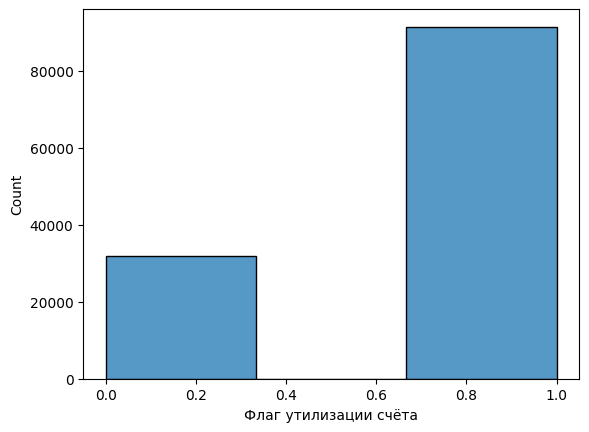

In [ ]:
sns.histplot(data=data['Флаг утилизации счёта'], bins=3)

<Axes: ylabel='Флаг утилизации счёта'>

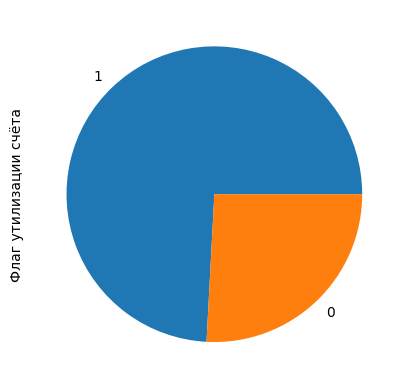

In [ ]:
data['Флаг утилизации счёта'].value_counts().plot.pie()

### 2. Альтернатива в критерии.

**Нулевая гипотеза** утверждает о том, что изменение процесса авторизации не окажет статистически значимого эффекта на позвышение частоты утилизации наших счетов по сравнению с контрольной группой.\
**Альтернативная гипотеза** утверждает о том, что изменение процесса авторизации окажет положительное влияние на частоту утилизаций счета в тестовой группе.

In [ ]:
alternative_2 = 'p_control < p_test' # односторонняя альтернатива

### 3. Нужно выбрать параметр(-ы), влияющий(-ие) на целевую метрику. Привести аргументацию.

Определим столбцы, которые могут быть рассмотрены как параметры, влияющие на целевую метрику. Поскольку в будущем мы будем проверять выборки на однородность, а в качестве признаков для проверки берут обычно соц-дем, финансовую активность или активность участия в самом продукте, рационально рассмотреть "нефинансовые для продукта" параметры такие как:
* Возраст;
* Доход клиента;
* Вероятность банкротства.

Зависимость параметров между собой определим с помощью коэффициента корреляции.\
Для наглядности построим тепловую карту корреляции признаков между собой.

In [ ]:
corr_matrix = data[['Флаг утилизации счёта', 'Возраст', 'Доход клиента',	'Вероятность банкротства']].corr(method='pearson') #Смотрим корреляцию по методу Пирсона, т.к. значения выражены в метрических шкалах во всех столбцах.

<Axes: >

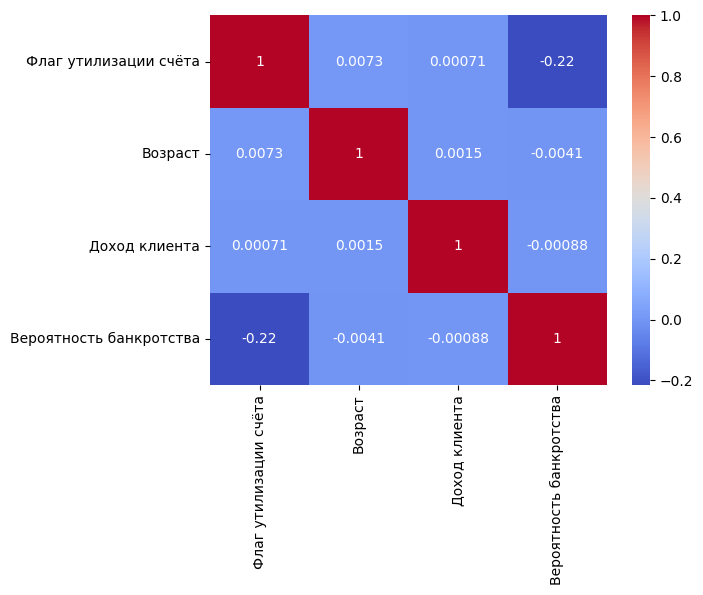

In [ ]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Проанализировав тепловую карту можно сделать следующий вывод:
Самая большая положительная корреляция с метрикой "Флаг утилизации счета" у параметра *Возраст*, однако, самая большая по модулю корреляция с целевой метрикой у параметра *Вероятность банкротства*. Отрицательное значение коэффициента корреляции объесняется логически: Чем выше вероятность банкротства, тем ниже вероятность одобрения крединой карты и, как следствие, утилизации счета (Действительно, что утилизировать, если выдачу карты не одобрили?).
Опираясь на вышесказанное примем в качестве параметра, **наиболее** влияющего на целевую метрику, ***Вероятность банкротства***.

### 4.1. Каков размер выборки? Привести аргументацию и написать как получилось то или иное число.

Для расчета выборки при бинарном распределении метрики (0 и 1) используется формула с базовой конверсией.
Определим **базовую конверсию** по столбцу *Флаг утилизации счёта* из исторических данных.

In [ ]:
p_base = data['Флаг утилизации счёта'].sum() / data['Флаг утилизации счёта'].count()
p_base

0.7415439535921463

Рассчитаем MDE.

In [ ]:
uplift = 0.03 #Мы хотим видеть 3%-ое увеличение базовой конверсии
mde_2 = uplift * p_base 
mde_2

0.02224631860776439

Опредлим критические значения Z.

In [ ]:
z_1_alpha5 = norm.ppf(1-.05) #alpha = 5% (0.05)

In [ ]:
z_beta5 = norm.ppf(.05) #beta = 5% (0.05)
z_beta5

-1.6448536269514729

Определим размер выборки.

In [ ]:
def sample_size_binomial(p_base, mde, z_alpha, z_beta):
  '''
  Функция расчета размера выборки (односторонняя альтернатива, бинарное распределение)
  аргументы функции:
  z_alpha - критическое значение z для z(1-alpha);
  z_beta - критическое значение z для z(beta);
  p_baze - базовая конверсия;
  mde - MDE (Minimum Detectable Effect)
  '''
  n = (2 * p_base * (1 - p_base) * (z_alpha - z_beta) ** 2) / (mde ** 2)
  return n

In [ ]:
print(f'Необходимый размер выборок n и m = {round(sample_size_binomial(p_base, mde_2, z_1_alpha5, z_beta5),0)} наблюдений.')

Необходимый размер выборок n и m = 8382.0 наблюдений.


### 4.2. Необходимо запросить у бота в Телеграме выборку полученного размера командой `/get_project2_sample {размер выборки}` и вписать <ins>код выборки</ins>:

In [ ]:
sample_code_2 = 10092 #Код выборки

### 5. Проверка на однородность, применение критерия. Принятие решения. Расписать подробно с аргументами.

После того, как мы получили 2 выборки (тест и контроль), необходимо проверить их гомогенность (однородность), чтобы мы могли предположить, что единственное чем отличаются выборки, это наличие влияния нашего теста.

#### Загрузка контрольной и тестовой выборок.

Подгрузим контрольную и тестовую выборки и оставим в них только столбец с интересующей нас метрикой и параметром, влияющим на эту метрику.

In [ ]:
control_2 = pd.read_csv('gdrive/My Drive/Контроль (1).csv')
control_2 = control_2[['Флаг утилизации счёта', 'Вероятность банкротства']]
test_2 = pd.read_csv('gdrive/My Drive/Тест (1).csv')
test_2 = test_2[['Флаг утилизации счёта', 'Вероятность банкротства']]

Посмотрим, как все подгрузилось.

In [ ]:
control_2.head()

,Флаг утилизации счёта,Вероятность банкротства
0,0,0.049579
1,1,0.008291
2,1,0.029141
3,1,0.225022
4,1,0.008637


In [ ]:
test_2.head()

,Флаг утилизации счёта,Вероятность банкротства
0,0,0.205598
1,0,0.132103
2,1,0.009616
3,1,0.077674
4,1,0.242047


#### Проверка Stability index выборок.

In [ ]:
si_2 = calculate_psi(control_2['Вероятность банкротства'], test_2['Вероятность банкротства'])
print(f'Stability Index = {round(si_2, 4)}')
if si < 0.1:
  print(f'В выборке отстуствуют значимые изменения.')
elif 0.1 <= si < 0.2:
  print(f'В выборке имеются незначительные изменения, которые необходимо исследовать.')
else:
  print(f'В выборке имеется существенное смещение, необходимы изменения, в идеале не использовать выборку.')

Stability Index = 0.004
В выборке отстуствуют значимые изменения.


#### Проверка однородности выборок.

Наши исходные данные: 1 признак, влияющий на целевую метрику, следовательно, для проверки однородности двух выборок будем использовать **метод Андерсона-Дарлинга**.\
Проверка однородности выбранного параметра осуществяется с **уровнем значимости 2%**.

In [ ]:
res = anderson_ksamp([control_2['Вероятность банкротства'], test_2['Вероятность банкротства']])

if res.pvalue < 0.02:
    print(f"Отвергаем нулевую гипотезу на уровне значимости 2%: Выборки неоднородны (p-value={res.pvalue})")
else:
    print(f"Не отвергаем нулевую гипотезу на уровне значимости 2%: Выборки однородны (p-value={res.pvalue})")

Не отвергаем нулевую гипотезу на уровне значимости 2%: Выборки однородны (p-value=0.16052781183278797)


Для самопроверки применим критерий **Лемана-Розенблатта**.

In [ ]:
res_2 = cramervonmises_2samp(control_2['Вероятность банкротства'], test_2['Вероятность банкротства'])

if res_2.pvalue < 0.02:
    print(f"Отвергаем нулевую гипотезу на уровне значимости 2%: Выборки неоднородны (p-value={res_2.pvalue})")
else:
    print(f"Не отвергаем нулевую гипотезу на уровне значимости 2%: Выборки однородны (p-value={res_2.pvalue})")

Не отвергаем нулевую гипотезу на уровне значимости 2%: Выборки однородны (p-value=0.21786250801885754)


#### Выбор и применение статистического критерия.

Поскольку выборки однородны, мы можем применить критерий для целевой метрики.
В качестве статистического критерия будем использовать один из самых популярных критериев для бинарных выборок - **Z-критерий Фишера**.

In [ ]:
alpha_2 = 0.05 # уровень значимости 5%

sample_success_a = control_2['Флаг утилизации счёта'].sum() # количество удачных исходов в контролькой выборке (утилизация счёта)
sample_size_a = control_2['Флаг утилизации счёта'].count() # общий размер испытаний в контрольой выборке

sample_success_b = test_2['Флаг утилизации счёта'].sum() # количество удачных исходов в тестовой выборке (утилизация счёта)
sample_size_b = test_2['Флаг утилизации счёта'].count() # общий размер испытаний в тестовой выборке

successes = np.array([sample_success_a, sample_success_b]) # массив успехов
samples = np.array([sample_size_a, sample_size_b]) # массив испытаний

stat, p_value = proportions_ztest(count=successes, nobs=samples, alternative='smaller') # In the two sample test, smaller means that the alternative hypothesis is p1 < p2

print(f'z_статистика: {round(stat, 4)}, p_value: {round(p_value, 4)}')
print('=================================')
if p_value < alpha_2:
    print("Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.")
else:
    print("Нулевая гипотеза не отвергается и статзначимых различий в группах нет.")

z_статистика: -2.9, p_value: 0.0019
Отвергаем нулевую гипотезу в пользу альтернативной гипотезы, имеются статзначимые ризличия в группах.


#### Выводы:

* Мы видим, что p_value = 0.0019 < alpha = 0.05, следовательно нулевая 
гипотеза H0 о том, что изменение процесса авторизации не окажет статистически значимого эффекта на позвышение частоты утилизации счетов по сравнению с контрольной группой, **отвергается** в пользу альтернативной гипотезы о наличии в тестовой выборке статзначимых изменений (**увеличения** конверсии утилизаций счёта на (как минимум) минимально-ожидаемый эффект) для уровня значимости alpha = 5% и мощности (1-beta) = 95%.
* Таким образом, опираясь на результаты теста мы принимаем решение (или даем рекомендацию) внедрить новый процесс авторизации (масштабировать на всех пользователей), в виду того, что это окажет статзначимый эффект на увеличение количества утилизаций счёта.
